# THIS JUPYTER NOTEBOOK IS USED TO DETERMINE THE LULC CHANGE FROM 2017 TO 2024 #

## ESRI LIVING ATLAS LAND USE LAND COVER DATA HAS BEEN USED IN THIS NOTEBOOK ##

### 1. IMPORTING THE REQUIRED PACKAGES ###

In [3]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import shape
from skimage import measure
import matplotlib.pyplot as plt
import pandas as pd

### 2. LOADING THE NECESSARY LULC RASTERS & AREA OF INTEREST VECTOR ###

#### NOTE: THESE RASTERS ARE DOWNLOADED FROM ESRI LIVING ATLAS ####

In [ ]:
# Input Rasters
folder = os.getcwd()
raster_names = [
    "45Q_20170101-20180101.tif",
    "45Q_20180101-20190101.tif",
    "45Q_20190101-20200101.tif",
    "45Q_20210101-20220101.tif",
    "45Q_20220101-20230101.tif",
    "45Q_20230101-20240101.tif",
    "45Q_20240101-20241231.tif"
]
raster_paths = [os.path.join(folder, name) for name in raster_names]
aoi_path = os.path.join(folder, "AOI.shp")

# Load AOI shapefile
aoi = gpd.read_file(aoi_path)
aoi_crs = aoi.crs
aoi_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 3. Display Raster Metadata 

In [ ]:

metadata_list = []
for path in raster_paths:
    with rasterio.open(path) as src:
        meta = {
            "RasterName": os.path.basename(path),
            "CRS": src.crs,
            "Width": src.width,
            "Height": src.height,
            "Band Count": src.count,
            "Dtype": src.dtypes[0],
            "Driver": src.driver
        }
        metadata_list.append(meta)

df_meta = pd.DataFrame(metadata_list).drop_duplicates()
display(df_meta)


In [ ]:
src.meta ## USED FOR INFORMATION ON CRS

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 64218,
 'height': 88853,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]'),
 'transform': Affine(10.0, 0.0, 178910.0,
        0.0, -10.0, 2657470.0)}

### 4. DISPLAY AOI VECTOR OVERLAYED ON OPEN STREET MAP

In [23]:
import folium
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image
from folium.raster_layers import ImageOverlay
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

# Choose one raster
raster_path = raster_paths[0]

with rasterio.open(raster_path) as src:
    # Reproject AOI to raster CRS
    if src.crs != aoi.crs:
        aoi_proj = aoi.to_crs(src.crs)
    else:
        aoi_proj = aoi

    # Crop to AOI
    geoms = [feature["geometry"] for feature in aoi_proj.__geo_interface__["features"]]
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

    # Downsample to smaller size for browser
    scale_factor = 0.1
    out_image = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor)
        ),
        resampling=Resampling.bilinear
    )

    bounds = rasterio.transform.array_bounds(out_image.shape[0], out_image.shape[1], out_transform)
    bounds_latlon = rasterio.warp.transform_bounds(src.crs, "EPSG:4326", *bounds)

    # Normalize raster to 0-255
    image_normalized = (255 * (out_image - out_image.min()) / (out_image.max() - out_image.min())).astype(np.uint8)

# Create folium map centered at AOI
center = aoi.to_crs("EPSG:4326").geometry.centroid.iloc[0]
m = folium.Map(location=[center.y, center.x], zoom_start=12)

# Add raster overlay
img = ImageOverlay(
    image=image_normalized,
    bounds=[[bounds_latlon[1], bounds_latlon[0]], [bounds_latlon[3], bounds_latlon[2]]],
    opacity=0.6,
    colormap=lambda x: (1, 0.7, 0.2, x)  # Customize color
)
img.add_to(m)

# Add AOI layer
folium.GeoJson(aoi.to_crs("EPSG:4326")).add_to(m)

m


C:\Users\Skywa\AppData\Local\Temp\ipykernel_4312\2147880124.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = aoi.to_crs("EPSG:4326").geometry.centroid.iloc[0]


### 6. LAND USE LAND COVER CLASSIFICATION BY ESRI LIVING ATLAS | THIS IS ALSO GIVEN IN ESRI LIVING ATLAS WEBSITE

In [ ]:
import pandas as pd
df = pd.read_excel("LULC_CLassification.xlsx")
from IPython.display import display, HTML
pd.set_option('display.max_rows', None)        
pd.set_option('display.max_columns', None)     
pd.set_option('display.max_colwidth', None)   
display(HTML(df.to_html(index=False)))


### 7. CLIPPING THE RASTERS TO AOI VECTOR & DISPLAYING THEM WITH CORRESPONDING HISTOGRAM 

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


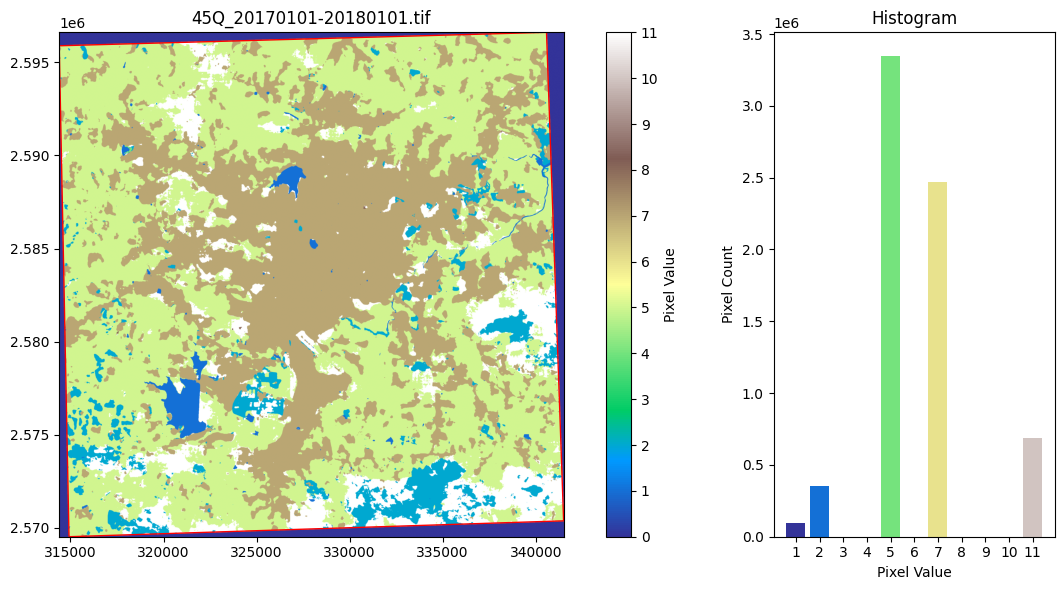

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


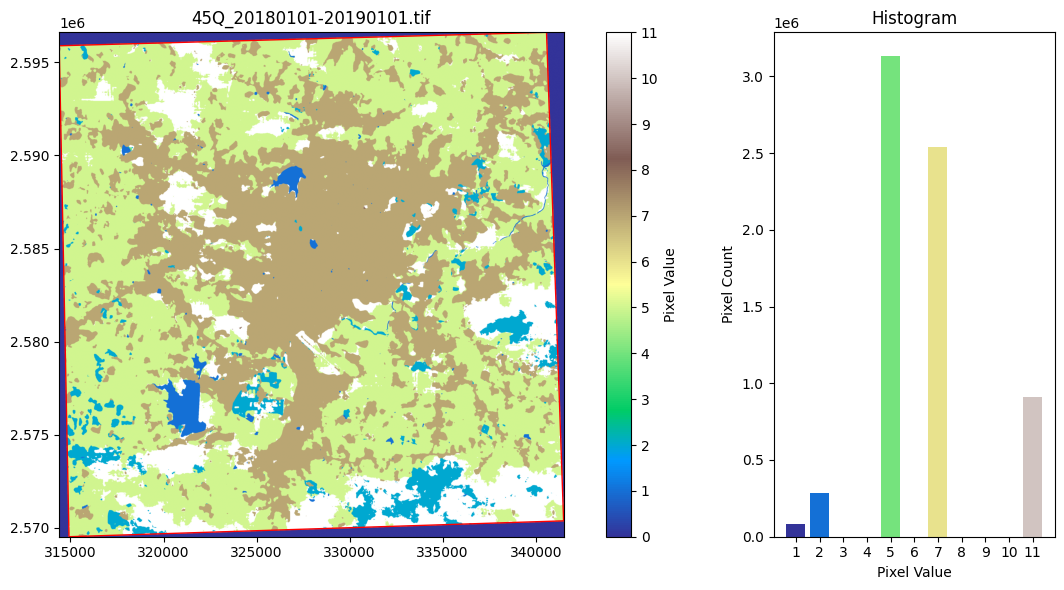

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


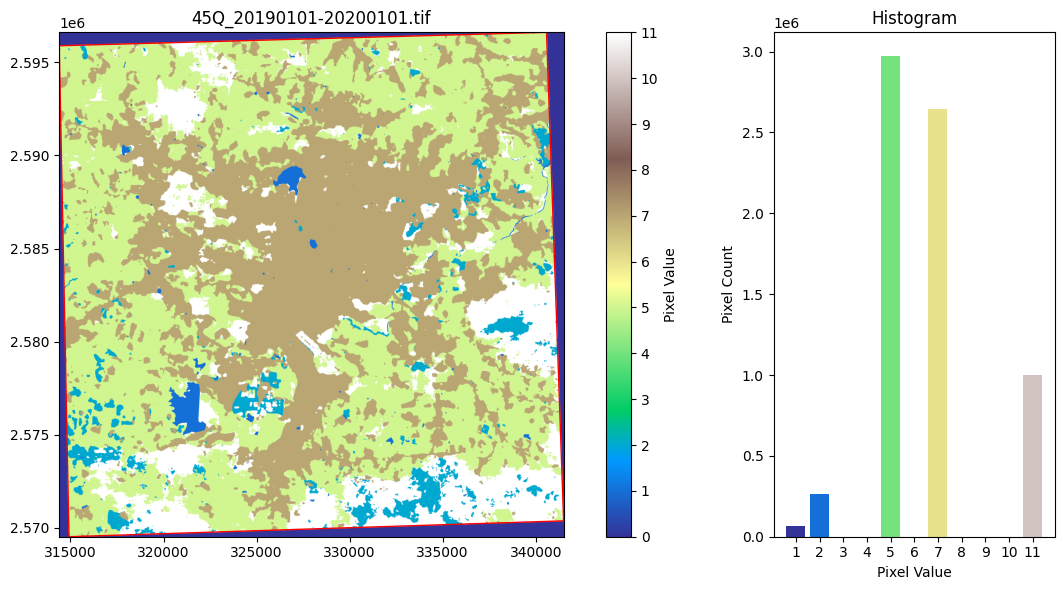

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


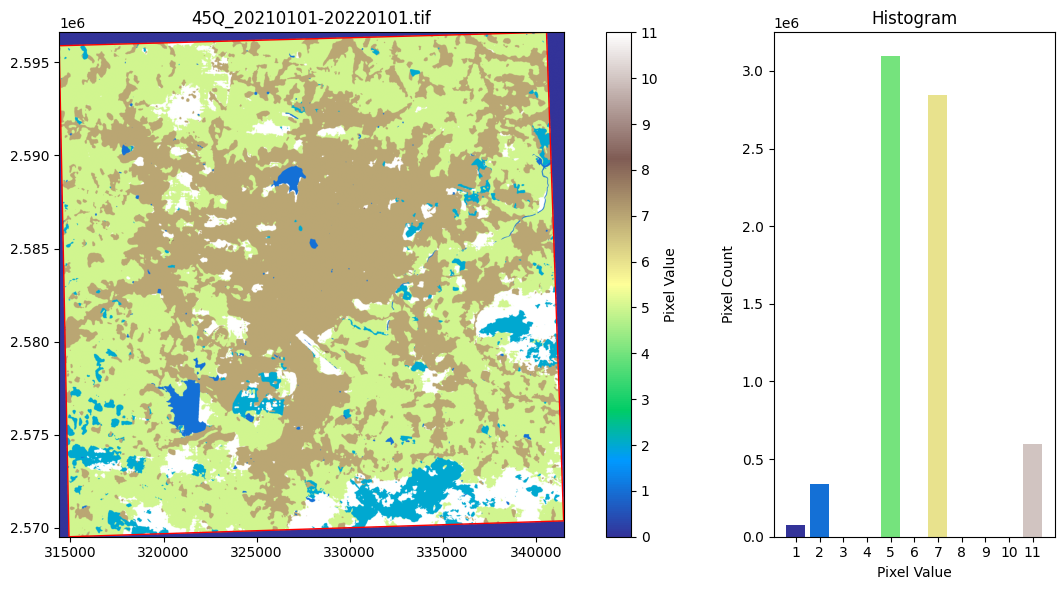

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


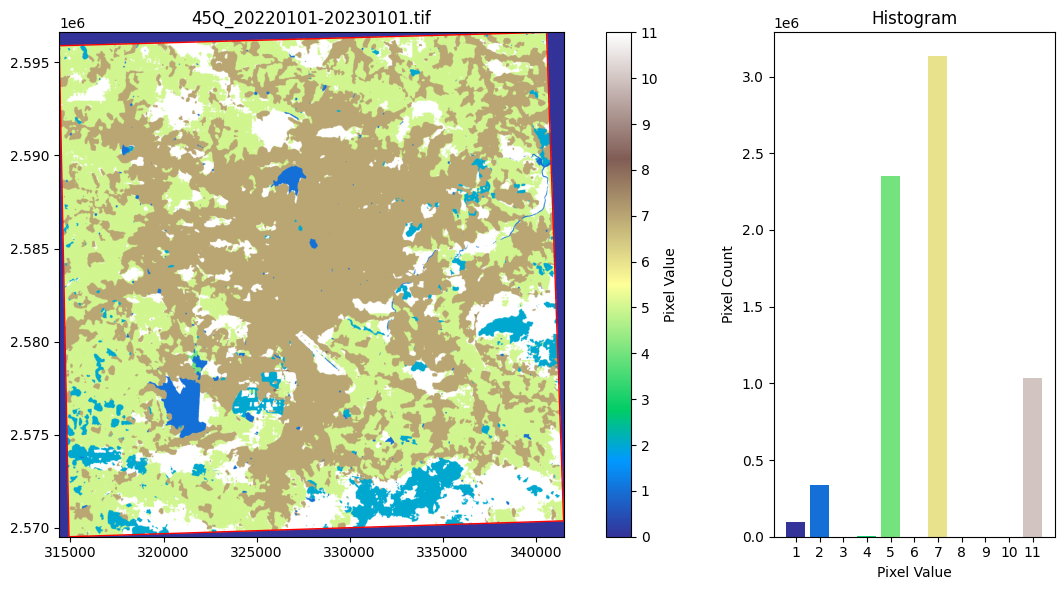

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


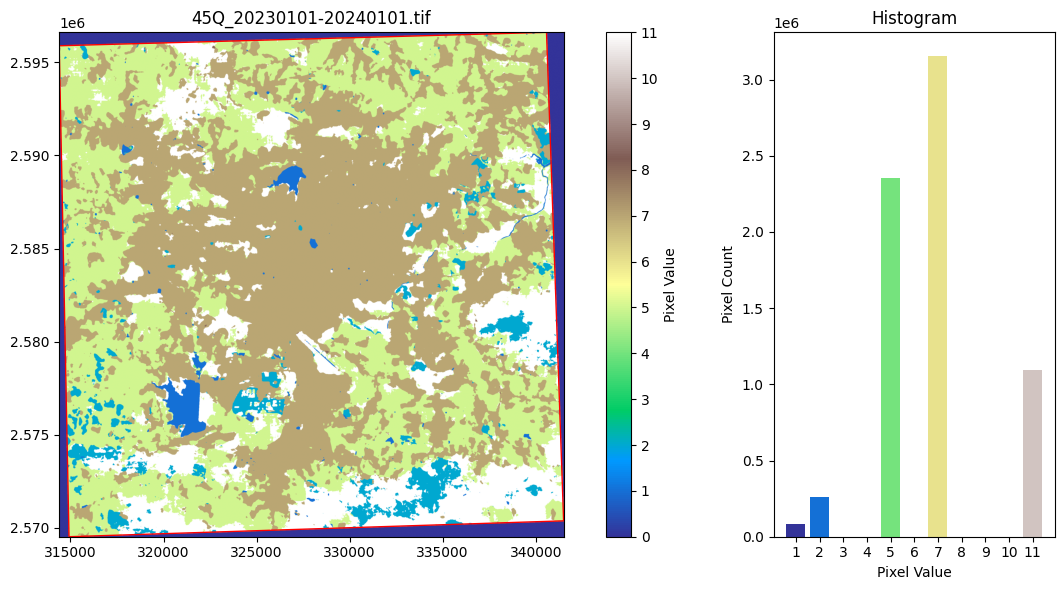

C:\Users\Skywa\AppData\Local\Temp\ipykernel_1636\2276017245.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("terrain")


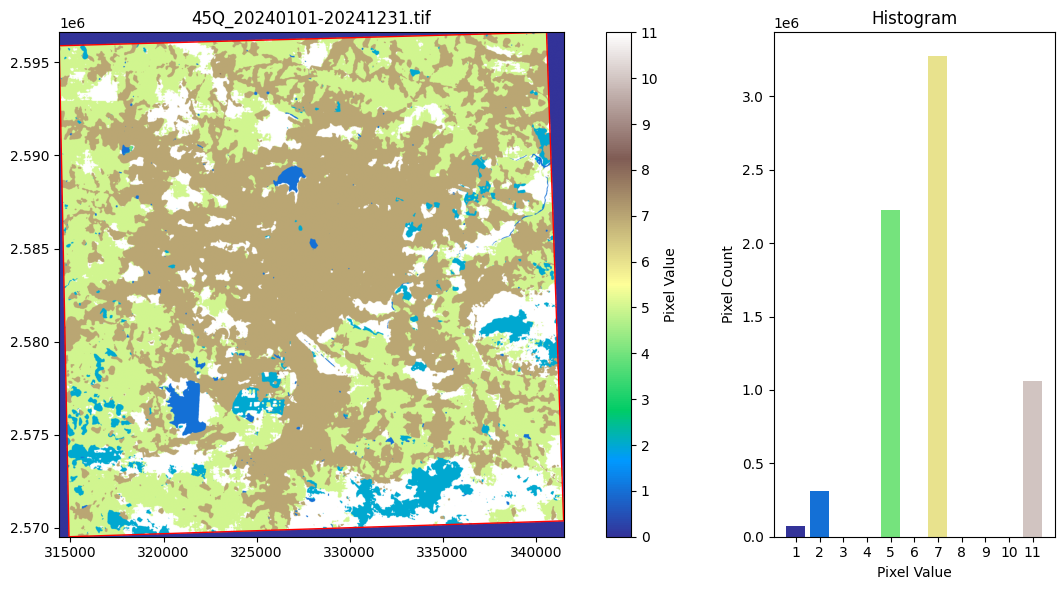

In [ ]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

for path in raster_paths:
    with rasterio.open(path) as src:
        
        aoi_proj = aoi.to_crs(src.crs) if src.crs != aoi.crs else aoi
        geoms = [feat["geometry"] for feat in aoi_proj.__geo_interface__["features"]]
        
        out_image, out_transform = mask(src, geoms, crop=True)
        data = out_image[0]  
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
        
        cmap = get_cmap("terrain")
        im = rasterio.plot.show(
            data,
            transform=out_transform,
            ax=ax1,
            cmap=cmap
        )
        aoi_proj.boundary.plot(ax=ax1, edgecolor="red", linewidth=1)
        
        minx, miny, maxx, maxy = aoi_proj.total_bounds
        ax1.set_xlim(minx, maxx)
        ax1.set_ylim(miny, maxy)
        ax1.set_title(os.path.basename(path))
       
        cbar = fig.colorbar(im.get_images()[0], ax=ax1, orientation='vertical', label='Pixel Value')
        cbar.set_ticks(range(int(data.min()), int(data.max()) + 1))  # Integer ticks for pixel values
        
        pixel_values = data.ravel()
        valid_pixels = pixel_values[pixel_values != src.nodata]  # Exclude nodata
        if valid_pixels.size > 0:
            hist, bins = np.histogram(valid_pixels, bins=range(int(valid_pixels.min()), int(valid_pixels.max()) + 2))         
            norm = Normalize(vmin=min(bins), vmax=max(bins))
            colors = [cmap(norm(b)) for b in bins[:-1]]
            ax2.bar(bins[:-1], hist, align='center', color=colors)
            ax2.set_xticks(bins[:-1])
            ax2.set_xlabel('Pixel Value')
            ax2.set_ylabel('Pixel Count')
            ax2.set_title('Histogram')
        else:
            ax2.text(0.5, 0.5, 'No valid data', ha='center', va='center')
            ax2.set_title('Histogram')
       
        plt.tight_layout()
        plt.show()

### 8. DISPLAY THE TABLE OF RASTERS VS PIXEL VALUES ALONGSIDE LULC CLASSIFICATION

In [ ]:
import pandas as pd
from IPython.display import display, HTML
import rasterio
from rasterio.mask import mask
import numpy as np

histogram_data = []
pixel_values_set = set()

for path in raster_paths:
    with rasterio.open(path) as src:
        
        aoi_proj = aoi.to_crs(src.crs) if src.crs != aoi.crs else aoi
        geoms = [feat["geometry"] for feat in aoi_proj.__geo_interface__["features"]]

        # Clip raster to AOI
        out_image, out_transform = mask(src, geoms, crop=True)
        data = out_image[0] 

        
        pixel_values = data.ravel()
        valid_pixels = pixel_values[pixel_values != src.nodata]  
        if valid_pixels.size > 0:
            hist, bins = np.histogram(valid_pixels, bins=range(int(valid_pixels.min()), int(valid_pixels.max()) + 2))
            hist_dict = {int(b): int(h) for b, h in zip(bins[:-1], hist)}
            pixel_values_set.update(hist_dict.keys())
            histogram_data.append((os.path.basename(path), hist_dict))


seen = set()
unique_histogram_data = []
for raster_name, hist_dict in histogram_data:
    if raster_name not in seen:
        seen.add(raster_name)
        unique_histogram_data.append((raster_name, hist_dict))
histogram_data = unique_histogram_data


pixel_values = sorted(pixel_values_set)
table_data = {val: [] for val in pixel_values}

for raster_name, hist_dict in histogram_data:
    for val in pixel_values:
        table_data[val].append(hist_dict.get(val, 0))


df_hist = pd.DataFrame(table_data, index=[name for name, _ in histogram_data])
df_hist.index.name = 'Raster'


lulc_data = pd.read_excel("LULC_CLassification.xlsx")
pd.set_option('display.max_rows', None)        
pd.set_option('display.max_columns', None)     
pd.set_option('display.max_colwidth', None)   
df_lulc = pd.DataFrame(lulc_data)


display(HTML(
    '<div style="display: flex; justify-content: space-between;">'
    '<div style="margin-right: 20px;">'
    '<h3>Histogram Table</h3>'
    f'{df_hist.to_html()}'
    '</div>'
    '<div>'
    '<h3>LULC Classification Table</h3>'
    f'{df_lulc.to_html(index=False)}'
    '</div>'
    '</div>'
))

### 9. DISPLAY THE AREA(SQKM) PER FEATURE FOR EACH RASTERS

In [ ]:
import pandas as pd
from IPython.display import display, HTML

lulc_data = {
    'Value': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Name': [
        'Water', 'Trees', 'N/A', 'Flooded vegetation', 'Crops', 'N/A', 'Built Area',
        'Bare ground', 'Snow/Ice', 'Clouds', 'Rangeland'
    ]
}
value_to_name = {val: name for val, name in zip(lulc_data['Value'], lulc_data['Name'])}

# Calculate area for each DN (pixel value) in each raster
# Each pixel is 10m x 10m = 100 square meters, convert to km²
pixel_area_m2 = 100  # Area per pixel in square meters
pixel_area_km2 = pixel_area_m2 / 1_000_000  # Convert to km² (100 m² / 1,000,000 = 0.0001 km²)

pixel_values = sorted(pixel_values_set)
area_data = {val: [] for val in pixel_values}

for raster_name, hist_dict in histogram_data:
    for val in pixel_values:
        pixel_count = hist_dict.get(val, 0)
        area_km2 = pixel_count * pixel_area_km2  # Area in square kilometers
        area_data[val].append(area_km2)


df_area = pd.DataFrame(area_data, index=[name for name, _ in histogram_data])
df_area.index.name = 'Raster'

df_area.columns = [value_to_name.get(val, str(val)) for val in df_area.columns]

display(HTML(
    '<div>'
    '<h3>Area per Features (km²)</h3>'
    f'{df_area.to_html()}'
    '</div>'
))

### 10. DISPLAY THE TABLE FOR AREA CHANGE BETWEEN 2017 & 2024

In [47]:
import pandas as pd
from IPython.display import display, HTML

# Define LULC class mapping
lulc_data = {
    'Value': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Name': [
        'WaterBodies', 'Trees', 'N/A', 'Flooded vegetation', 'Crops', 'N/A', 'Built Area',
        'Bare ground', 'Snow/Ice', 'Clouds', 'Rangeland'
    ]
}
value_to_name = {val: name for val, name in zip(lulc_data['Value'], lulc_data['Name'])}

# Calculate area for each DN in km²
pixel_area_km2 = 100 / 1_000_000  # 100 m² per pixel converted to km² (0.0001 km²)

# Extract areas for the two rasters
raster_2017 = '45Q_20170101-20180101.tif'
raster_2024 = '45Q_20240101-20241231.tif'

# Find the histogram data for the two rasters
area_2017 = {}
area_2024 = {}
for raster_name, hist_dict in histogram_data:
    if raster_name == raster_2017:
        for val in pixel_values_set:
            pixel_count = hist_dict.get(val, 0)
            area_2017[val] = pixel_count * pixel_area_km2
    elif raster_name == raster_2024:
        for val in pixel_values_set:
            pixel_count = hist_dict.get(val, 0)
            area_2024[val] = pixel_count * pixel_area_km2

# Calculate the change in area for each LULC class
change_data = {
    'Class': [],
    'Area 2017 (km²)': [],
    'Area 2024 (km²)': [],
    'Change (km²)': [],
    'Change (%)': []
}

for val in sorted(pixel_values_set):
    class_name = value_to_name.get(val, str(val))
    area_2017_val = area_2017.get(val, 0)
    area_2024_val = area_2024.get(val, 0)
    change_km2 = area_2024_val - area_2017_val
    # Calculate percentage change: (change / initial area) * 100, avoid division by zero
    change_percent = (change_km2 / area_2017_val * 100) if area_2017_val != 0 else 0

    change_data['Class'].append(class_name)
    change_data['Area 2017 (km²)'].append(area_2017_val)
    change_data['Area 2024 (km²)'].append(area_2024_val)
    change_data['Change (km²)'].append(change_km2)
    change_data['Change (%)'].append(change_percent)

# Build DataFrame for change table
df_change = pd.DataFrame(change_data)
df_change.set_index('Class', inplace=True)
# Round the 'Change (%)' column to 2 decimal places
df_change['Change (%)'] = df_change['Change (%)'].round(2)

# Display the change table
display(HTML(
    '<div>'
    '<h3>LULC Change (2017 to 2024)</h3>'
    f'{df_change.to_html()}'
    '</div>'
))

#### FURTHER PROCESS OF MAKING THE MAP WITH LEGENDS IS DONE IN QGIS BECAUSE AFTER SEVERAL ATTEMPT I WAS NOT SUCCESSFUL IN JUPYTER NOTEBOOK. 

### 11. CLIPPING THE RASTERS WITH VECTOR AOI, SAVING IT ON THE LOCAL DRIVE

In [ ]:
clipped_rasters = []
for i, path in enumerate(raster_paths):
    with rasterio.open(path) as src:
        if src.crs != aoi_crs:
            aoi_proj = aoi.to_crs(src.crs)
        else:
            aoi_proj = aoi
        geoms = [feature["geometry"] for feature in aoi_proj.__geo_interface__["features"]]
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        output_path = os.path.join(folder, f"clipped_{i}.tif")
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
        clipped_rasters.append(output_path)


### 12. POLYGONIZE THE CLIPPED RASTERS

In [ ]:
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd

polygonized_paths = []

for i, raster_path in enumerate(clipped_rasters):
    with rasterio.open(raster_path) as src:
        band = src.read(1)
        mask_data = band != src.nodata

        results = []
        for geom, value in shapes(band, mask=mask_data, transform=src.transform):
            if value is not None:
                results.append({
                    "geometry": shape(geom),
                    "DN": int(value)
                })

        gdf = gpd.GeoDataFrame(results, crs=src.crs)
        output_path = os.path.join(folder, f"polygonized_{i}.gpkg")
        gdf.to_file(output_path, driver='GPKG')
        polygonized_paths.append(output_path)


### 13. DISPLAY THE POLYGONS WITH A COMMON COLOUR RAMP

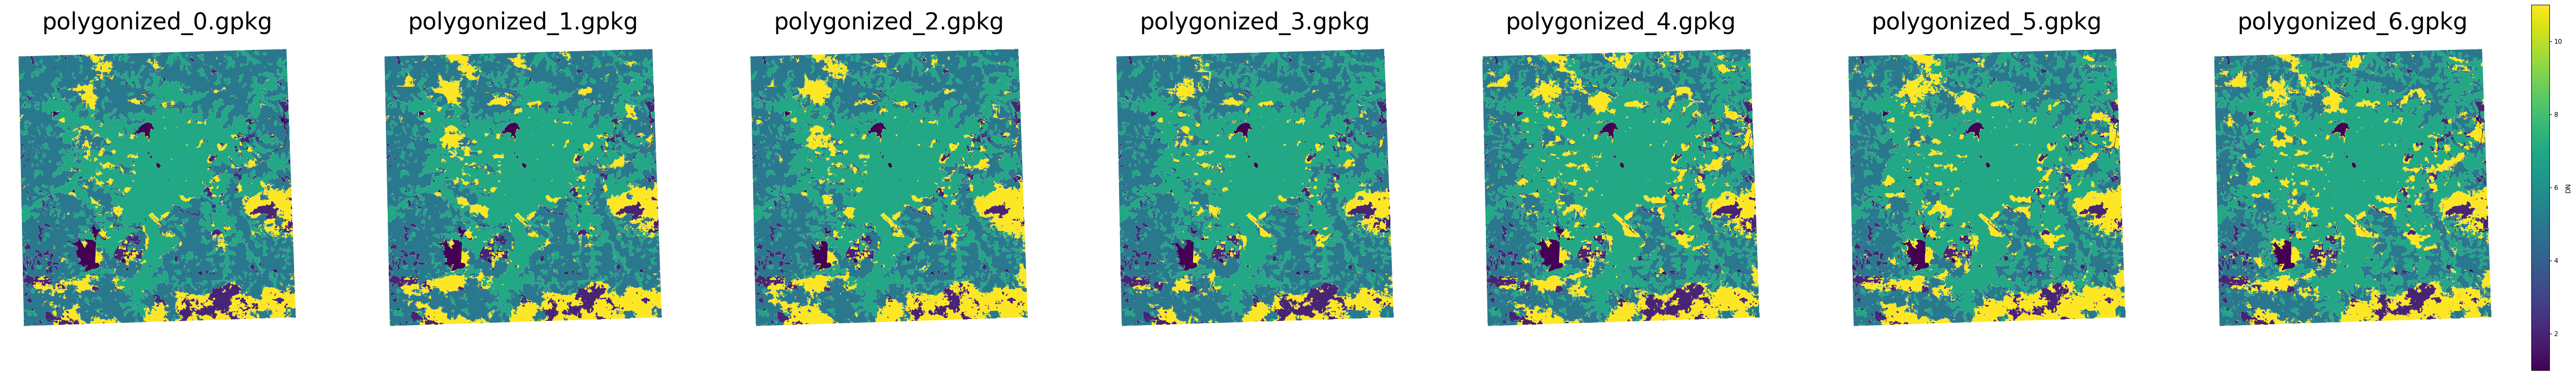

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import os

# Step 1: Load all GeoDataFrames and find global DN range
gdfs = []
dn_values = []

for path in polygonized_paths:
    gdf = gpd.read_file(path)
    gdfs.append(gdf)
    dn_values.extend(gdf['DN'].dropna().unique())

dn_min, dn_max = int(min(dn_values)), int(max(dn_values))

# Step 2: Create color normalization and colormap
cmap = plt.cm.viridis  # or 'viridis', 'tab20', etc.
norm = mcolors.Normalize(vmin=dn_min, vmax=dn_max)

# Step 3: Plot horizontally
n = len(gdfs)
fig, axes = plt.subplots(1, n, figsize=(10 * n, 10), constrained_layout=False)

if n == 1:
    axes = [axes]  # make iterable if only one subplot

for ax, gdf, path in zip(axes, gdfs, polygonized_paths):
    gdf.plot(column='DN', cmap=cmap, norm=norm, ax=ax, legend=False)
    ax.set_title(os.path.basename(path), fontsize=35)
    ax.axis('off')

# Step 4: Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # dummy array for ScalarMappable
fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label="DN")

plt.show()


### 14. DISSOLVE THE VECTORS WITH SPECIFIC FEATURE

In [ ]:
dissolved_paths = []
for i, path in enumerate(polygonized_paths):
    gdf = gpd.read_file(path)
    dissolved = gdf.dissolve(by='DN')
    output_path = os.path.join(folder, f"dissolved_{i}.gpkg")
    dissolved.to_file(output_path, driver='GPKG')
    dissolved_paths.append(output_path)

### 15. LOADING THE DISSOLVED VECTOR IN THIS NOTEBOOK

In [3]:
import geopandas as gpd

gdf_2017 = gpd.read_file("dissolved_0.gpkg")
gdf_2024 = gpd.read_file("dissolved_6.gpkg")

# Ensure same CRS
if gdf_2017.crs != gdf_2024.crs:
    gdf_2024 = gdf_2024.to_crs(gdf_2017.crs)


### 16. DISPLAY THE AREA OF BOTH YEAR 2017 & 2024

In [14]:
import pandas as pd
from IPython.display import HTML

# Drop unwanted columns from each
cols_to_drop = ["geometry", "Area (SQM)", "Class_Description"]

# Create cleaned tables
table_2017 = gdf_2017.drop(columns=cols_to_drop, errors='ignore').copy()
table_2024 = gdf_2024.drop(columns=cols_to_drop, errors='ignore').copy()

# Rename columns to indicate year (optional, if overlapping)
table_2017.columns = [f"{col}_2017" for col in table_2017.columns]
table_2024.columns = [f"{col}_2024" for col in table_2024.columns]

# Reset index for clarity
table_2017.reset_index(drop=True, inplace=True)
table_2024.reset_index(drop=True, inplace=True)

# Combine side-by-side
combined_table = pd.concat([table_2017, table_2024], axis=1)

# Display
HTML(combined_table.to_html(index=False))


### 17. DISPLAY THE BAR CHART TO SHOW THE NET CHANGE OF EACH FEATURE CLASS

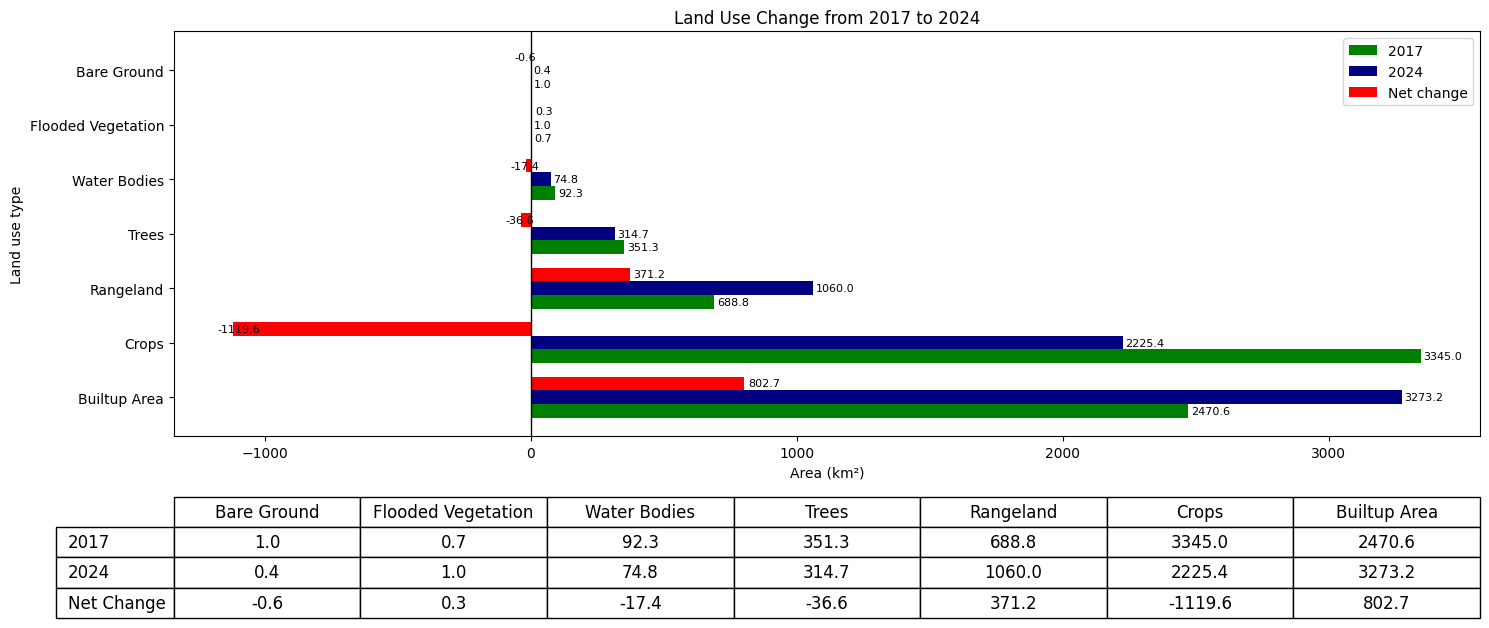

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Normalize LULC class names
gdf_2017["LULC_Class"] = gdf_2017["LULC_Class"].str.title().str.strip()
gdf_2024["LULC_Class"] = gdf_2024["LULC_Class"].str.title().str.strip()

# Group and sum area by class
area_2017 = gdf_2017.groupby("LULC_Class")["Area (SQKM)"].sum()
area_2024 = gdf_2024.groupby("LULC_Class")["Area (SQKM)"].sum()

# Combine into DataFrame
df = pd.DataFrame({
    "2017": area_2017,
    "2024": area_2024
})
df["Net change"] = df["2024"] - df["2017"]

# Sort by 2024 values
df = df.sort_values("2024", ascending=True)

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))
y = range(len(merged))
bar_height = 0.25

y = range(len(df))
bar_height = 0.25

# Plot bars
ax.barh([i + bar_height for i in y], df["2017"], height=bar_height, color="green", label="2017")
ax.barh(y, df["2024"], height=bar_height, color="navy", label="2024")
ax.barh([i - bar_height for i in y], df["Net change"], height=bar_height, color="red", label="Net change")

# Center vertical line at x=0
ax.axvline(0, color='black', linewidth=1)

# Add labels
for i, cls in enumerate(df.index):
    ax.text(df["2017"].iloc[i] + 10, i + bar_height, f"{df['2017'].iloc[i]:.1f}", va="center", fontsize=8)
    ax.text(df["2024"].iloc[i] + 10, i, f"{df['2024'].iloc[i]:.1f}", va="center", fontsize=8)
    ax.text(df["Net change"].iloc[i] + (15 if df["Net change"].iloc[i] > 0 else -60), i - bar_height, 
            f"{df['Net change'].iloc[i]:.1f}", va="center", fontsize=8)

# Axis setup
ax.set_yticks(y)
ax.set_yticklabels(df.index)
ax.invert_yaxis()
ax.set_xlabel("Area (km²)")
ax.set_ylabel("Land use type")
ax.legend()
ax.set_title("Land Use Change from 2017 to 2024")

# Table data
table_data = [
    [f"{x:.1f}" for x in df["2017"]],
    [f"{x:.1f}" for x in df["2024"]],
    [f"{x:.1f}" for x in df["Net change"]]
]
col_labels = df.index.tolist()
row_labels = ["2017", "2024", "Net Change"]

# Add table inside plot
table = plt.table(cellText=table_data,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  cellLoc='center',
                  loc='bottom',
                  bbox=[0.0, -0.45, 1.0, 0.3])  # x, y, width, height

table.auto_set_font_size(False)
table.set_fontsize(12)

plt.subplots_adjust(left=0.1, bottom=0.35)  # make room for table
plt.tight_layout()
plt.show()
